In [27]:
import matplotlib.pyplot as plt
import numpy as  np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import RFECV





In [28]:
df = pd.read_csv('Data.csv', delimiter=';')
print(df.head())

   Device_type            Timestamp Heart rate  Activity type Sleep stage  \
0  Apple Watch  20250602074248+0200         42              0       Awake   
1  Apple Watch  20250602074813+0200         58              1       Awake   
2  Apple Watch  20250602075146+0200         60              1       Awake   
3  Apple Watch  20250602075658+0200         75              0       Awake   
4  Apple Watch  20250602080402+0200         84              0       Awake   

   Caffeine  
0         0  
1         0  
2         0  
3         0  
4         0  


# 2. Exploratory Data Analysis
<!-- <h1 style="color:darkblue;">2. Exploratory Data Analysis</h1> -->

In [29]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y%m%d%H%M%S%z", errors="coerce")
df["Heart rate"] = pd.to_numeric(df["Heart rate"], errors="coerce")

### Plot Activity-Type, Sleep-Stage counts 

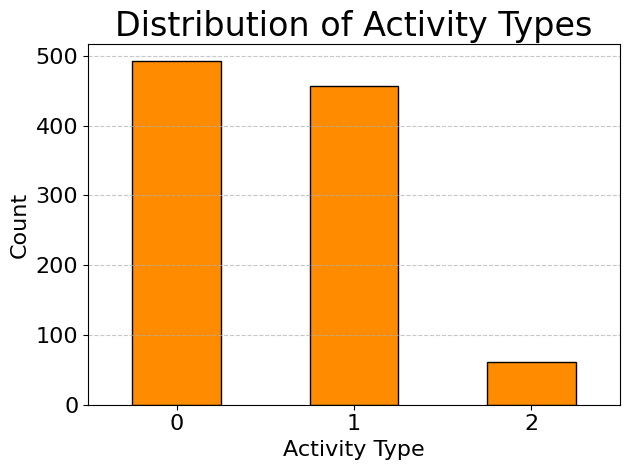

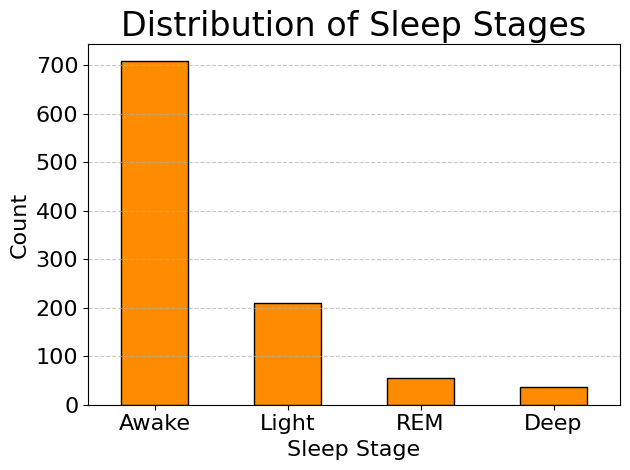

KeyError: 'Caffeine'

In [140]:
#Activity type
activity_counts = df["Activity type"].value_counts(dropna=False)
activity_counts.index = activity_counts.index.fillna("Missing")
activity_counts.plot(kind='bar', color='darkorange', edgecolor='black')
plt.xlabel("Activity Type", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Distribution of Activity Types", fontsize=24)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig(os.path.expanduser('~/Desktop/activity_type.png'), dpi=300)
plt.show()

#Sleep stage
activity_counts = df["Sleep stage"].value_counts(dropna=False)
activity_counts.index = activity_counts.index.fillna("Missing")
activity_counts.plot(kind='bar', color='darkorange', edgecolor='black')
plt.xlabel("Sleep Stage", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Distribution of Sleep Stages", fontsize=24)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig(os.path.expanduser('~/Desktop/sleep_stage.png'), dpi=300)
plt.show()

#Caffeine
activity_counts = df["Caffeine"].value_counts(dropna=False)
activity_counts.index = activity_counts.index.fillna("Missing")
activity_counts.plot(kind='bar', color='darkorange', edgecolor='black')
plt.xlabel("Caffeine", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Distribution of Caffeine", fontsize=24)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig(os.path.expanduser('~/Desktop/sleep_stage.png'), dpi=300)
plt.show()

### Create various intervals (5min, 10min, 15min)

In [30]:
#Creating various intervals
def resample_df(df, interval="10min"):
    """
    Resample numerical and categorical columns in a time-indexed DataFrame.

    Parameters:
        df (pd.DataFrame): Input dataframe with a 'Timestamp' column.
        interval (str): Time interval string for resampling (e.g., '10min', '1H').

    Returns:
        pd.DataFrame: Resampled dataframe with 'Timestamp' as a column.
    """
    # Ensure Timestamp is parsed and set as index
    df = df.copy()
    df.columns = df.columns.str.strip()
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
    df["Heart rate"] = pd.to_numeric(df["Heart rate"], errors="coerce")
    df = df.set_index("Timestamp").sort_index()

    # Define columns
    numerical_cols = ["Heart rate"]
    categorical_cols = ["Activity type", "Sleep stage", "Caffeine"]

    # Convert categoricals to string to avoid numeric aggregation
    for col in categorical_cols:
        df[col] = df[col].astype(str)

    # Resample numericals using mean
    numerical_resampled = df[numerical_cols].resample(interval).mean()

    # Resample categoricals using mode
    categorical_resampled = pd.DataFrame(index=numerical_resampled.index)
    for col in categorical_cols:
        categorical_resampled[col] = df[col].resample(interval).agg(
            lambda x: x.mode().iloc[0] if not x.mode().empty else None
        )

    # Combine and reset index
    df_resampled = pd.concat([numerical_resampled, categorical_resampled], axis=1).reset_index()

    return df_resampled

df_5min = resample_df(df, "5min")
df_10min = resample_df(df, "10min")
df_15min = resample_df(df, "15min")

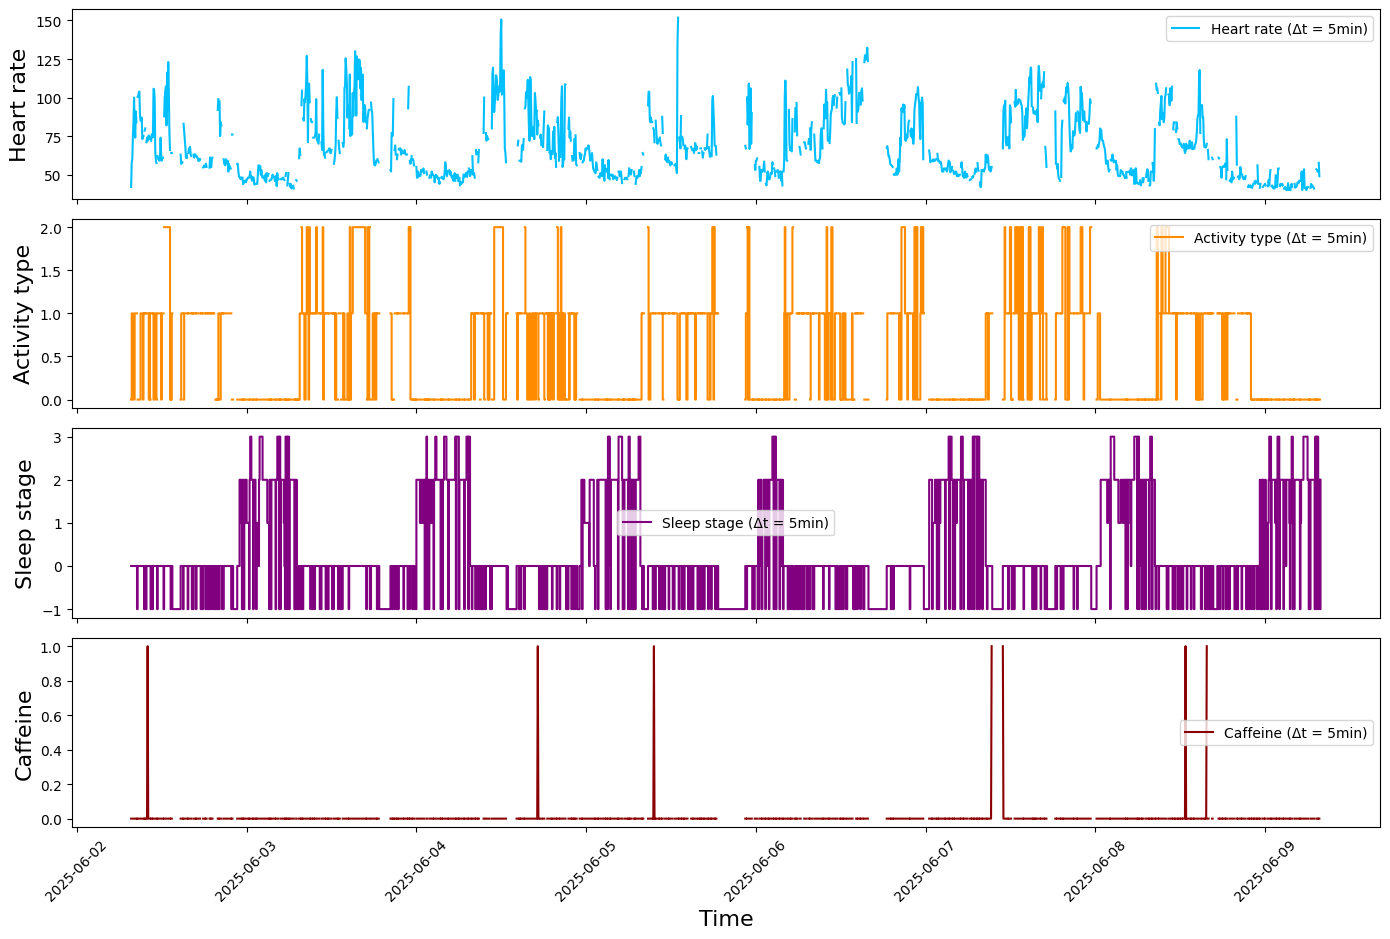

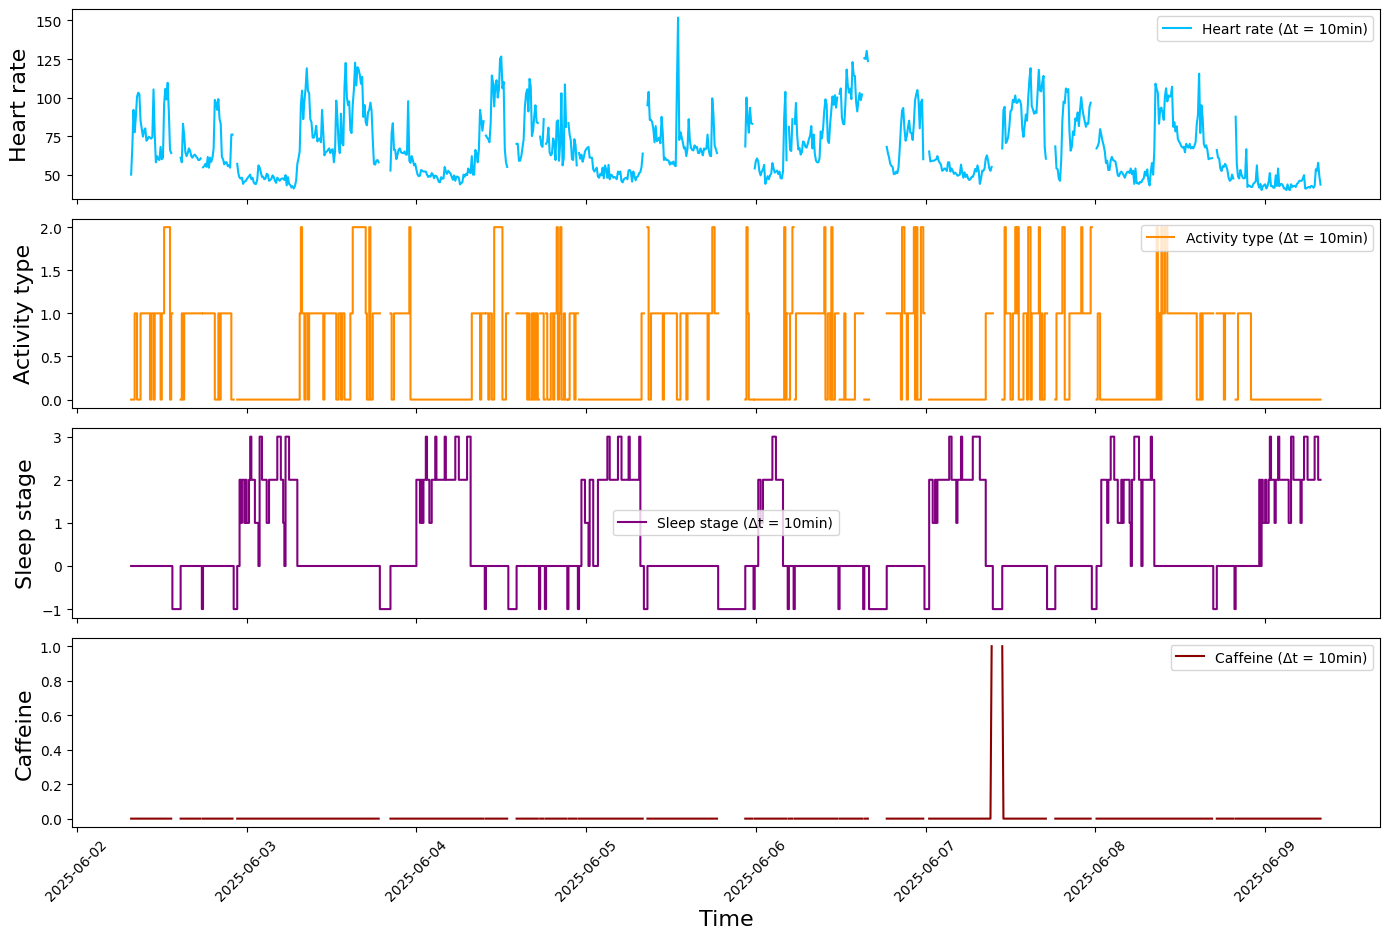

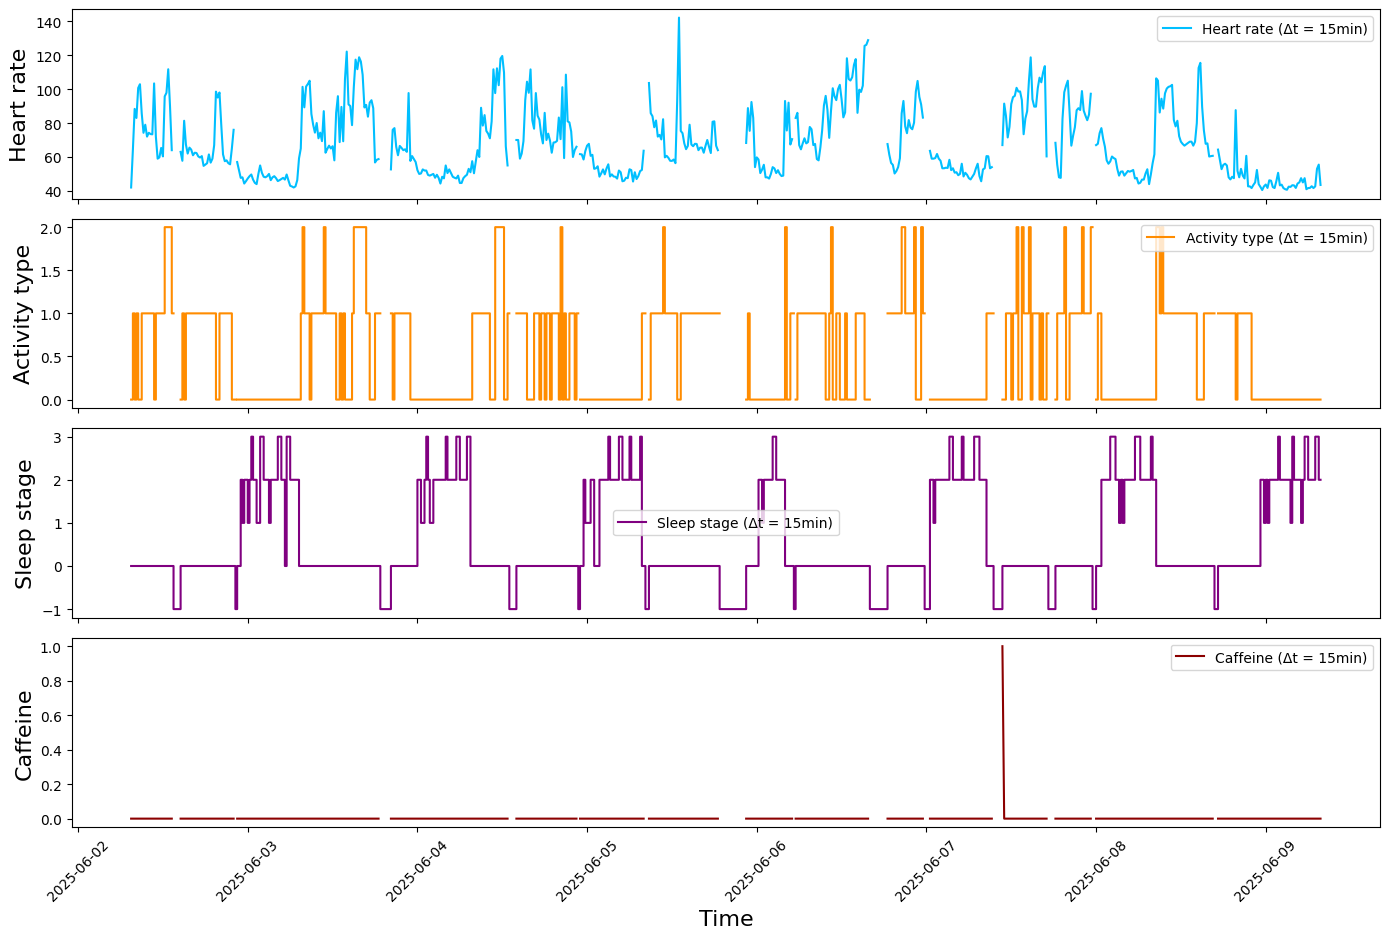

In [31]:
def plot_sensor_overview(df_resampled, interval_label="10min", save_path="/Users/dora/Desktop/timeseries_plot.png"):
    """
    Plots 4 sensor/categorical measurements over time in subplots.
    
    Parameters:
        df_resampled (pd.DataFrame): Resampled dataframe with 'Timestamp' as a column.
        interval_label (str): Label for the time interval (e.g., '10min') to show in the title and legends.
        save_path (str): File path to save the resulting plot image.
    """

    # Ensure timestamp is in datetime format and set as index
    df_resampled = df_resampled.copy()
    df_resampled["Timestamp"] = pd.to_datetime(df_resampled["Timestamp"], errors="coerce")
    df_resampled = df_resampled.set_index("Timestamp")

    # Clean caffeine column
    df_resampled["Caffeine"] = pd.to_numeric(df_resampled["Caffeine"], errors="coerce")

    # Set up figure and axes
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 10), sharex=True)

    # Plot 1: Heart rate
    axs[0].plot(df_resampled.index,
                df_resampled["Heart rate"],
                label=f"Heart rate (Δt = {interval_label})",
                color='deepskyblue')
    axs[0].set_ylabel("Heart rate", fontsize=16)
    axs[0].legend()

    # Plot 2: Activity type
    axs[1].plot(df_resampled.index,
                pd.to_numeric(df_resampled["Activity type"], errors='coerce'),
                drawstyle='steps-post',
                label=f"Activity type (Δt = {interval_label})",
                color='darkorange')
    axs[1].set_ylabel("Activity type", fontsize=16)
    axs[1].legend()

    # Plot 3: Sleep stage
    axs[2].plot(df_resampled.index,
                df_resampled["Sleep stage"].astype("category").cat.codes,
                drawstyle='steps-post',
                label=f"Sleep stage (Δt = {interval_label})",
                color='purple')
    axs[2].set_ylabel("Sleep stage", fontsize=16)
    axs[2].legend()

    # Plot 4: Caffeine
    axs[3].plot(df_resampled.index,
                df_resampled["Caffeine"],
                label=f"Caffeine (Δt = {interval_label})",
                color='darkred')
    axs[3].set_ylabel("Caffeine", fontsize=16)
    axs[3].legend()

    # Final formatting
    axs[-1].set_xlabel("Time", fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leaves space for suptitle
    plt.savefig(save_path, dpi=300)
    plt.show()

plot_sensor_overview(df_5min, interval_label="5min", save_path=os.path.expanduser('~/Desktop/5.png'))
plot_sensor_overview(df_10min, interval_label="10min", save_path=os.path.expanduser('~/Desktop/10.png'))
plot_sensor_overview(df_15min, interval_label="15min", save_path=os.path.expanduser('~/Desktop/15.png'))

In [32]:
#For further anlysis we use df_10min
df = df_10min
print(df.isna().sum())

Timestamp          0
Heart rate       105
Activity type    105
Sleep stage      105
Caffeine         105
dtype: int64


# 3. Data Preprocessing
<!-- <h1 style="color:darkblue;">3. Data Preprocessing</h1> -->

### Data Cleaning

In [14]:
# # Clean Caffeine Column
# df["Caffeine"] = pd.to_numeric(df["Caffeine"], errors="coerce").fillna(0).astype(float)
# # for ts, val in df.loc[df["Caffeine"] > 0, ["Timestamp", "Caffeine"]].values:
# #     print(ts.strftime("%Y-%m-%d %H:%M"), val)

### Outlier Removal

In [33]:
lower, upper = df['Heart rate'].quantile([0.01, 0.99])
df['Heart rate'] = df['Heart rate'].clip(lower, upper)

### Imputation

In [34]:
# Forward fill
df['Heart rate'] = df['Heart rate'].ffill()
df['Activity type'] = df['Activity type'].ffill()
df['Sleep stage'] = df['Sleep stage'].ffill()
df['Caffeine'] = df['Caffeine'].ffill()

# Then interpolate linearly (for longer gaps)
# df['Heart rate'] = df['Heart rate'].interpolate()
print(df.isna().sum())

Timestamp        0
Heart rate       0
Activity type    0
Sleep stage      0
Caffeine         0
dtype: int64


### Kalman Filter (smooths out heart rate)

In [35]:
def kalman_1d(zs, Q=1e-5, R=0.1):
    x = zs[0]
    P = 1.0
    filtered = []
    for z in zs:
        # Predict
        P += Q
        # Update
        K = P / (P + R)
        x += K * (z - x)
        P *= (1 - K)
        filtered.append(x)
    return filtered

df['Heart rate'] = kalman_1d(df['Heart rate'].values)
print(df.head())

                  Timestamp  Heart rate Activity type Sleep stage Caffeine
0 2025-06-02 07:40:00+02:00   50.000000             0       Awake        0
1 2025-06-02 07:50:00+02:00   58.333817             0       Awake        0
2 2025-06-02 08:00:00+02:00   69.195848             0       Awake        0
3 2025-06-02 08:10:00+02:00   71.222004             1       Awake        0
4 2025-06-02 08:20:00+02:00   74.415773             1       Awake        0


# 4. Feature Engineering

### Time -> (Day-of-Week, Hour, Minute)

In [36]:
df["hour"] = df["Timestamp"].dt.hour
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)  # Cyclic
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)  # Cyclic
df["minute"] = df["Timestamp"].dt.minute
df["day_of_week"] = df["Timestamp"].dt.dayofweek 
print(df.head())

                  Timestamp  Heart rate Activity type Sleep stage Caffeine  \
0 2025-06-02 07:40:00+02:00   50.000000             0       Awake        0   
1 2025-06-02 07:50:00+02:00   58.333817             0       Awake        0   
2 2025-06-02 08:00:00+02:00   69.195848             0       Awake        0   
3 2025-06-02 08:10:00+02:00   71.222004             1       Awake        0   
4 2025-06-02 08:20:00+02:00   74.415773             1       Awake        0   

   hour  hour_sin  hour_cos  minute  day_of_week  
0     7  0.965926 -0.258819      40            0  
1     7  0.965926 -0.258819      50            0  
2     8  0.866025 -0.500000       0            0  
3     8  0.866025 -0.500000      10            0  
4     8  0.866025 -0.500000      20            0  


### Caffeine -> (Caffeine-Left, Hours-since-Caffeine)

In [37]:
# Caffeine left in body
half_life, dose = 5, 75
events, caffeine_left = [], []

for t, c in zip(df["Timestamp"], df["Caffeine"]):
    events = [(et, d) for et, d in events if (t - et).total_seconds() < 24*3600]
    total = sum(d * 0.5 ** ((t - et).total_seconds() / 3600 / half_life) for et, d in events)
    if c == 1.0:
        events.append((t, dose))
        total += dose
    caffeine_left.append(total)

df["caffeine_left"] = pd.Series(caffeine_left).round(3)

# Print
# for ts, val in df.loc[df["caffeine_left"] > 0, ["Timestamp", "caffeine_left"]].values:
#     print(ts.strftime("%Y-%m-%d %H:%M"), val)
print(df.head())

                  Timestamp  Heart rate Activity type Sleep stage Caffeine  \
0 2025-06-02 07:40:00+02:00   50.000000             0       Awake        0   
1 2025-06-02 07:50:00+02:00   58.333817             0       Awake        0   
2 2025-06-02 08:00:00+02:00   69.195848             0       Awake        0   
3 2025-06-02 08:10:00+02:00   71.222004             1       Awake        0   
4 2025-06-02 08:20:00+02:00   74.415773             1       Awake        0   

   hour  hour_sin  hour_cos  minute  day_of_week  caffeine_left  
0     7  0.965926 -0.258819      40            0              0  
1     7  0.965926 -0.258819      50            0              0  
2     8  0.866025 -0.500000       0            0              0  
3     8  0.866025 -0.500000      10            0              0  
4     8  0.866025 -0.500000      20            0              0  


In [38]:
# Hours since Caffeine intake
last, hours_since = None, []

for t, c in zip(df["Timestamp"], df["Caffeine"]):
    last = t if c == 1 else last
    hours_since.append(0 if c == 1 else ((t - last).total_seconds() / 3600) if last else np.nan)

df["hours_since_caffeine"] = hours_since
print(df.head())

                  Timestamp  Heart rate Activity type Sleep stage Caffeine  \
0 2025-06-02 07:40:00+02:00   50.000000             0       Awake        0   
1 2025-06-02 07:50:00+02:00   58.333817             0       Awake        0   
2 2025-06-02 08:00:00+02:00   69.195848             0       Awake        0   
3 2025-06-02 08:10:00+02:00   71.222004             1       Awake        0   
4 2025-06-02 08:20:00+02:00   74.415773             1       Awake        0   

   hour  hour_sin  hour_cos  minute  day_of_week  caffeine_left  \
0     7  0.965926 -0.258819      40            0              0   
1     7  0.965926 -0.258819      50            0              0   
2     8  0.866025 -0.500000       0            0              0   
3     8  0.866025 -0.500000      10            0              0   
4     8  0.866025 -0.500000      20            0              0   

   hours_since_caffeine  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN 

In [39]:
# Drop Caffeine column
df.drop(columns=["Caffeine"], inplace=True)

### Heart Rate -> (rolling_mean/std/min/max/range, change, percent-change, low-medium-high)

In [41]:
n = 5
df["hr_rolling_mean"] = df["Heart rate"].rolling(window=n).mean()  # smooths heart rate (trend)
df["hr_rolling_std"] = df["Heart rate"].rolling(window=n).std()    # heart rate variability (volatility)
df["hr_min"] = df["Heart rate"].rolling(window=n).min()            # rolling minimum over n points
df["hr_max"] = df["Heart rate"].rolling(window=n).max()            # rolling maximum over n points
df["hr_range"] = df["hr_max"] - df["hr_min"]                       # range in n-point window
df["hr_diff"] = df["Heart rate"].diff()                            # immediate heart rate change
df["hr_pct_change"] = df["Heart rate"].pct_change()                # relative heart rate change (%)
df["hr_level"] = pd.cut(df["Heart rate"], bins=[0, 60, 90, np.inf], labels=["low", "medium", "high"]) 
hr_dummies = pd.get_dummies(df["hr_level"], prefix="hr_level").astype(int)
df = pd.concat([df, hr_dummies], axis=1)
df.drop(columns=["hr_level"], inplace=True)


### Sleep stage -> (categorical, previous-stage, is-same, duration)

In [15]:
df["Sleep stage"] = df["Sleep stage"].astype("category").cat.codes
df["prev_stage"] = df["Sleep stage"].shift(1)                             # previous sleep stage   
df["is_same_as_prev"] = (df["Sleep stage"] != df["prev_stage"]).astype(int)  # is same as previous stage ?
df["stage_duration"] = df["is_same_as_prev"].groupby((~df["is_same_as_prev"]).cumsum()).cumsum()  # duration in current stage (resets on change)

# 5. Model: Random Forest

In [43]:
cols_to_fill = [
    "hours_since_caffeine",
    "hr_rolling_mean",
    "hr_rolling_std",
    "hr_min",
    "hr_max",
    "hr_range",
    "hr_diff",
    "hr_pct_change"
]

# First forward fill, then backward fill to catch topmost NaNs
df[cols_to_fill] = df[cols_to_fill].ffill().bfill()
print(df.isna().sum())

Timestamp                  0
Heart rate                 0
Activity type              0
Sleep stage                0
hour                       0
hour_sin                   0
hour_cos                   0
minute                     0
day_of_week                0
caffeine_left              0
hours_since_caffeine    1010
hr_rolling_mean            0
hr_rolling_std             0
hr_min                     0
hr_max                     0
hr_range                   0
hr_diff                    0
hr_pct_change              0
hr_level_low               0
hr_level_medium            0
hr_level_high              0
hr_level_low               0
hr_level_medium            0
hr_level_high              0
dtype: int64


In [44]:
print(df.head())


                  Timestamp  Heart rate Activity type Sleep stage  hour  \
0 2025-06-02 07:40:00+02:00   50.000000             0       Awake     7   
1 2025-06-02 07:50:00+02:00   58.333817             0       Awake     7   
2 2025-06-02 08:00:00+02:00   69.195848             0       Awake     8   
3 2025-06-02 08:10:00+02:00   71.222004             1       Awake     8   
4 2025-06-02 08:20:00+02:00   74.415773             1       Awake     8   

   hour_sin  hour_cos  minute  day_of_week  caffeine_left  ...     hr_max  \
0  0.965926 -0.258819      40            0              0  ...  74.415773   
1  0.965926 -0.258819      50            0              0  ...  74.415773   
2  0.866025 -0.500000       0            0              0  ...  74.415773   
3  0.866025 -0.500000      10            0              0  ...  74.415773   
4  0.866025 -0.500000      20            0              0  ...  74.415773   

    hr_range    hr_diff  hr_pct_change  hr_level_low  hr_level_medium  \
0  24.415773 

In [69]:
#Function to train models
def train_and_evaluate(X, y, model, param_grid, model_name="Model", label_names=None, use_rfecv=True):
    # 0. Feature selection (optional)
    if use_rfecv:
        print(f"\n🧪 Running RFECV for feature selection on {model_name}...")
        rfecv = RFECV(
            estimator=model,
            step=1,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring="f1_macro",
            n_jobs=-1
        )
        rfecv.fit(X, y)
        X = X.loc[:, rfecv.support_]
        print("✅ Selected features:", list(X.columns))

    # 1. Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 2. Cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # 3. Grid search with F1 macro
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # 4. Predict and evaluate
    y_pred = grid_search.best_estimator_.predict(X_test)

    print(f"\n🔍 {model_name}")
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best CV F1 Macro Score:", grid_search.best_score_)
    print("Test F1 Macro Score:", f1_score(y_test, y_pred, average="macro"))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_names if label_names else None))

    # 5. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names if label_names else sorted(set(y)))
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"{model_name}", fontsize=24)
    plt.xlabel("Predicted Label",fontsize=20)
    plt.ylabel("True Label", fontsize=20)
    plt.xticks( fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    filename = os.path.expanduser(f"~/Desktop/{model_name.replace(' ', '_').lower()}_confusion_matrix.png")
    plt.savefig(filename, dpi=300)
    plt.show()

    return grid_search.best_estimator_
y = df["Sleep stage"]
X = df.drop(columns=["Sleep stage", "Timestamp", "hours_since_caffeine"])



🧪 Running RFECV for feature selection on Random Forest...
✅ Selected features: ['Heart rate', 'Activity type', 'hour', 'hour_sin', 'hour_cos', 'minute', 'day_of_week', 'hr_rolling_mean', 'hr_rolling_std', 'hr_min', 'hr_max', 'hr_range', 'hr_diff', 'hr_pct_change', 'hr_level_low', 'hr_level_medium', 'hr_level_low', 'hr_level_medium']

🔍 Random Forest
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV F1 Macro Score: 0.5708640433737465
Test F1 Macro Score: 0.4840164899882215

Classification Report:
              precision    recall  f1-score   support

       Awake       0.99      0.99      0.99       142
        Deep       0.00      0.00      0.00         7
       Light       0.67      0.93      0.78        42
         REM       1.00      0.09      0.17        11

    accuracy                           0.89       202
   macro avg       0.67      0.50      0.48       202
weighted avg       0.89      0.89      0.87       20

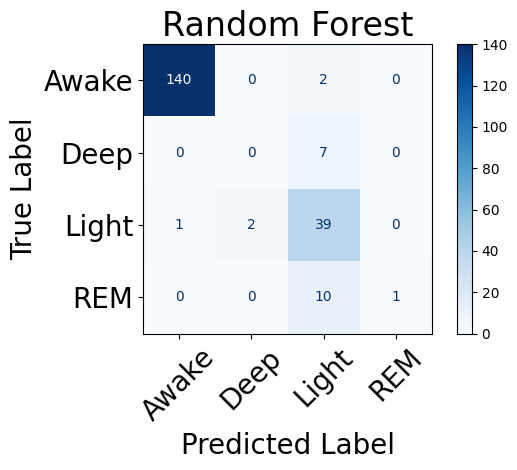

In [70]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

best_rf = train_and_evaluate(X, y, rf_model, rf_grid, model_name="Random Forest")



🔍 k-NN
Best hyperparameters: {'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best CV F1 Macro Score: 0.5402191441630018
Test F1 Macro Score: 0.5458959299831504

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       142
           1       0.33      0.14      0.20         7
           2       0.69      0.86      0.77        42
           3       0.33      0.18      0.24        11

    accuracy                           0.88       202
   macro avg       0.59      0.54      0.55       202
weighted avg       0.87      0.88      0.87       202



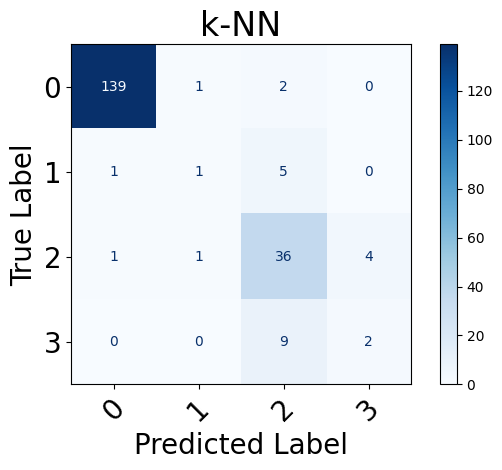

In [67]:
# k-NN (with scaling)
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])
knn_grid = {
    "knn__n_neighbors": [3, 5, 7],
    "knn__weights": ["uniform", "distance"]
}

best_knn = train_and_evaluate(X, y, knn_pipeline, knn_grid, model_name="k-NN", use_rfecv=False)

/Users/dora/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:30:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dora/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:30:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dora/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:30:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dora/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:30:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warni

Selected features: ['Heart rate', 'Activity type', 'hour', 'hour_sin', 'hour_cos', 'minute', 'day_of_week', 'hr_rolling_mean', 'hr_rolling_std', 'hr_min', 'hr_max', 'hr_range', 'hr_diff', 'hr_pct_change']


/Users/dora/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [15:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 XGBoost
Best hyperparameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 200}
Best CV F1 Macro Score: 0.5628671281301751
Test F1 Macro Score: 0.5732524920813664

Classification Report:
              precision    recall  f1-score   support

       Awake       0.99      0.99      0.99       142
        Deep       0.33      0.14      0.20         7
       Light       0.70      0.93      0.80        42
         REM       1.00      0.18      0.31        11

    accuracy                           0.90       202
   macro avg       0.76      0.56      0.57       202
weighted avg       0.91      0.90      0.88       202



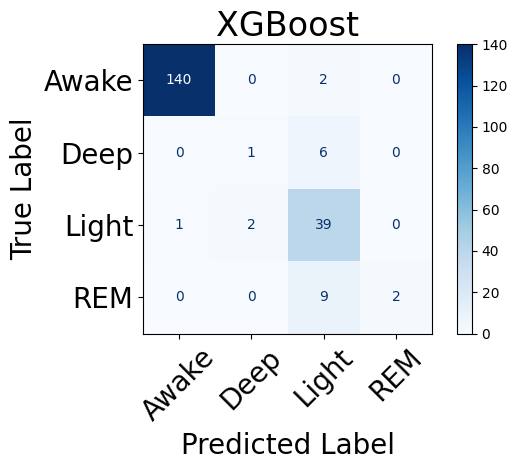

In [68]:
#XGBoost
from sklearn.preprocessing import LabelEncoder

# 1. Prepare data
le = LabelEncoder()
y = le.fit_transform(df["Sleep stage"])
label_names = le.classes_  # ['Awake', 'Deep', 'Light', 'REM']
X = df.drop(columns=["Sleep stage", "Timestamp", "hours_since_caffeine"])

# 2. Define the raw model (not in pipeline yet!)
xgb = XGBClassifier(
    objective="multi:softmax",
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

# 3. RFECV
rfecv = RFECV(
    estimator=xgb,
    step=1,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1_macro",
    n_jobs=-1
)

# 4. Fit RFECV and transform X
X_selected = rfecv.fit_transform(X, y)

print("Selected features:", X.columns[rfecv.support_].tolist())

# 5. Now prepare your pipeline with scaling and the same model
xgb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", xgb)
])

# 6. Define the hyperparameter grid
xgb_grid = {
    "xgb__n_estimators": [100, 200],
    "xgb__max_depth": [3, 6],
    "xgb__learning_rate": [0.1, 0.01]
}

# 7. Call your existing training function using the reduced feature set
best_xgb = train_and_evaluate(X_selected, y, xgb_pipeline, xgb_grid, model_name="XGBoost", label_names=label_names, use_rfecv=False)